In [1]:
import pandas as pd
import json
import numpy as np
from fastai.tabular.all import *
from fastcore.utils import *
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as fuck

In [2]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-10-27 22:58:22.877166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 22:58:23.143498: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-27 22:58:23.807853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /programs/anaconda3/envs/data_engineering_venv/lib/
2022-10-27 22:58:23.808012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: li

In [3]:
x = pd.read_csv(
        '../data_engineering/datasets/merged/us_cities_homes_sold_below_listing_and_price_cuts_rdc_data_w_macroecon.csv',
        dtype={'month_day_yyymm': str, 'county_fip': str, 'quality_flag': str, 'unemployment_rate': float}, )
x.drop(x.tail(1).index, inplace=True)
x = x.replace('none', np.nan)
# statepre = x['county_name'].str.split(', ', expand=True)[1]
# x = pd.concat([x, statepre],axis=1)
# x = x.rename(columns={1:'StatePre'})
# x["population_county_annual"] = x["population_county_annual"].astype(str).astype(float)

pd.options.mode.chained_assignment = None  # default='warn'

x["median_listing_price"].interpolate(method='linear',inplace=True,limit_direction='both' )
x["unemployment_rate"].interpolate(method='linear',inplace=True, limit_direction='both')
x["active_listing_count"].interpolate(method='linear',inplace=True, limit_direction='both')
x["median_days_on_market"].interpolate(method='linear',inplace=True, limit_direction='both')
# x["population_county_annual"] = x[["population_county_annual", "StatePre"]].groupby("StatePre").transform(lambda x: x.fillna(x.mean()))
x["30yr_interest_rate"].interpolate(method='linear',inplace=True, limit_direction='both')
# x["inflation_rate"].interpolate(method='linear',inplace=True)
# x["federal_fund_rate"].interpolate(method='linear',inplace=True)
# x["Quarterly_GDP_State_Chained_2012"] = x[["Quarterly_GDP_State_Chained_2012", "StatePre"]].groupby("StatePre").transform(lambda x: x.fillna(x.mean()))

d2 = x[['Date', 'county_name','median_listing_price','unemployment_rate','active_listing_count','median_days_on_market', '30yr_interest_rate']]
d3 = d2.groupby('county_name').filter(lambda x : len(x)==74)
d3['Date'] =  pd.to_datetime(d3['Date'], format='%Y-%m')

d3 = d3.set_index('Date')

/tmp/ipykernel_1045753/1792947496.py:1: DtypeWarning: Columns (37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  x = pd.read_csv(


In [4]:
d3[d3["county_name"]=="zavala, tx"]

,county_name,median_listing_price,unemployment_rate,active_listing_count,median_days_on_market,30yr_interest_rate
Date,,,,,,
2022-08-01,"zavala, tx",139500.0,0.0,4.0,105.0,5.2225
2022-07-01,"zavala, tx",150000.0,10.7,4.0,79.0,5.4125
2022-06-01,"zavala, tx",129000.0,10.8,6.0,74.0,5.5220
2022-05-01,"zavala, tx",129000.0,9.7,5.0,46.0,5.2300
2022-04-01,"zavala, tx",129000.0,9.5,4.0,155.0,4.9825
...,...,...,...,...,...,...
2016-11-01,"zavala, tx",170000.0,12.6,3.0,132.0,3.7700
2016-10-01,"zavala, tx",170000.0,14.1,3.0,114.0,3.4700
2016-09-01,"zavala, tx",150000.0,15.9,6.0,80.0,3.4600


# PREPROCESS BARK BARK

In [5]:
# Preprocess dat
# Because this is panel data so I will split each county data 

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

class DWrapper:
    def __init__(self, xtrain,xtest,ytrain,ytest):
        self.x_train = xtrain
        self.x_test = xtest
        self.y_train = ytrain
        self.y_test = ytest
        
def my_train_test_split(data, yvar):

    size=int(len(data)*0.90)

    x_train =data.drop(columns=[f'{yvar}']).iloc[0:size] 
    x_test = data.drop(columns=[f'{yvar}']).iloc[size:]
    
    y_train=data[f'{yvar}'].iloc[0:size] 
    y_test=data[f'{yvar}'].iloc[size:] 
    
    return x_train, x_test, y_train, y_test



def clean_splitted(d):
    scaler = StandardScaler()
    county=list(set(d.county_name))
    X_train=[]
    X_test=[]
    Y_train=[]
    Y_test=[]
    global c
    
    # scalar numeric

    cols = list(d.columns)
    cols.remove('county_name')
    # cols.remove('Date')

    print('Scalar fit transforming to standardscaler')
    d[cols] = scaler.fit_transform(d[cols])
    
    for i in range(0,len(county)):
        data=d[d['county_name']==county[i]]
        data.sort_values(inplace=True, by='Date', ascending=True)
        c = county[i]
        if i%200 == 0:
            print(c)
        # apply train_test_split for each county
        if data.shape[0] != data["median_listing_price"].shape[0]:
            print(c)
            print(data)
        
        x_train, x_test, y_train, y_test=my_train_test_split(data, 'median_listing_price')
        X_train.append(x_train)
        X_test.append(x_test)
        Y_train.append(y_train)
        Y_test.append(y_test)
    
    # concatenate test and trains from lists by counties
    X_train=pd.concat(X_train)
    Y_train=pd.DataFrame(pd.concat(Y_train))
    # concatenate each test dataset in X_test list and Y_test list respectively
    X_test=pd.concat(X_test)
    Y_test=pd.DataFrame(pd.concat(Y_test))
    
    # one hot encode each split
    print("one hot xtrain")
    X_train=pd.get_dummies(X_train,columns=['county_name'])
    print("one hot xtest")
    X_test=pd.get_dummies(X_test,columns=['county_name'])
    
    return X_train, Y_train, X_test, Y_test


def scale_reshape(X_train, Y_train, X_test, Y_test):
    track = [X_train, X_test, Y_train, Y_test]
    
    train = X_train.values
    test = X_test.values

    x_train = train.reshape((train.shape[0], 1, train.shape[1]))
    x_test = test.reshape((test.shape[0], 1, test.shape[1]))
    
    # call reshape_data for final splits
    print("Call wrapper reshape")
    return DWrapper(x_train, x_test, Y_train, Y_test)


# Preprocessing

############## ONE HOT ENCODE ########################



In [6]:
# Cleaned split and encoded of full dataframe
X_train, Y_train, X_test, Y_test = clean_splitted(d3)

Scalar fit transforming to standardscaler
cook, il
georgetown, sc
mahnomen, mn
cambria, pa
greene, in
st. john the baptist, la
parmer, tx
st. joseph, in
barbour, wv
warren, ms
caribou, id
butler, al
haskell, ks
baxter, ar
perry, pa
one hot xtrain
one hot xtest


In [7]:
len(list(X_train.columns))

2937

In [8]:
import warnings
warnings.filterwarnings('ignore')

reshaped_data = scale_reshape(X_train, Y_train, X_test, Y_test)

Call wrapper reshape


In [9]:
reshaped_data.y_train.shape, reshaped_data.x_train.shape 

((193578, 1), (193578, 1, 2937))

In [10]:
# debugging... why try except no work in this cluster?
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
c
d3[d3["county_name"]==c]

,county_name,median_listing_price,unemployment_rate,active_listing_count,median_days_on_market,30yr_interest_rate
Date,,,,,,
2022-08-01,"kalkaska, mi",0.375,-1.654,-0.278,-0.743,2.017
2022-07-01,"kalkaska, mi",0.543,0.428,-0.274,-1.079,2.288
2022-06-01,"kalkaska, mi",0.639,0.580,-0.286,-1.158,2.445
2022-05-01,"kalkaska, mi",0.545,0.428,-0.311,-1.178,2.028
2022-04-01,"kalkaska, mi",0.505,0.693,-0.325,-0.565,1.674
2022-03-01,"kalkaska, mi",0.870,0.958,-0.334,0.107,0.517
2022-02-01,"kalkaska, mi",0.329,1.450,-0.330,0.305,-0.067
2022-01-01,"kalkaska, mi",0.272,1.412,-0.322,0.048,-0.521
2021-12-01,"kalkaska, mi",0.172,0.807,-0.317,-0.446,-1.016


In [11]:
reshaped_data.y_train.shape
r = reshaped_data

# FINALLY SOME LSTM

In [12]:
# stop call
from keras.callbacks import Callback


class EarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs={}):
    
        if(logs.get('mae') < 0.03):
          print("\nMAEthreshold reached. Training stopped.")
          self.model.stop_training = True


## BLSTM dense tanh

In [13]:
# try bidirectional
#https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# https://keras.io/api/layers/recurrent_layers/bidirectional/
# https://www.google.com/search?q=why+only+one+layer+is+enough+lstm&oq=why+only+one+layer+is+enough+lstm&aqs=chrome..69i57j33i160l3j33i299l3.3544j0j1&sourceid=chrome&ie=UTF-8
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional

from keras.preprocessing import sequence

blstm_model = Sequential()
blstm_model.reset_states()
blstm_model.add(Bidirectional(LSTM(64, activation='relu', dropout=0.5, recurrent_activation='tanh', input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=False)))

# model.add(Dropout(0.09))
blstm_model.add(Dense(1, activation='tanh'))

blstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
# https://medium.com/@canerkilinc/selecting-optimal-lstm-batch-size-63066d88b96b#:~:text=By%20experience%2C%20in%20most%20cases,based%20on%20the%20performance%20observation. 
# optimal batch size = 60
blstm = blstm_model.fit(r.x_train, r.y_train, epochs=30, batch_size=160, validation_split=0.1,  verbose=1, shuffle=False)

2022-10-27 22:58:53.414283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 22:58:53.556701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 22:58:53.556944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 22:58:53.557194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/30
1089/1089 [==============================] - 7s 5ms/step - loss: 0.7042 - mse: 0.7042 - mae: 0.5313 - val_loss: 1.5320 - val_mse: 1.5320 - val_mae: 0.5789
Epoch 2/30
1089/1089 [==============================] - 5s 4ms/step - loss: 0.6170 - mse: 0.6170 - mae: 0.4673 - val_loss: 1.5011 - val_mse: 1.5011 - val_mae: 0.5809
Epoch 3/30
1089/1089 [==============================] - 5s 4ms/step - loss: 0.5037 - mse: 0.5037 - mae: 0.3895 - val_loss: 1.5050 - val_mse: 1.5050 - val_mae: 0.5884
Epoch 4/30
1089/1089 [==============================] - 5s 5ms/step - loss: 0.4555 - mse: 0.4555 - mae: 0.3535 - val_loss: 1.5091 - val_mse: 1.5091 - val_mae: 0.5898
Epoch 5/30
1089/1089 [==============================] - 5s 4ms/step - loss: 0.4406 - mse: 0.4406 - mae: 0.3431 - val_loss: 1.5086 - val_mse: 1.5086 - val_mae: 0.5900
Epoch 6/30
1089/1089 [==============================] - 5s 4ms/step - loss: 0.4319 - mse: 0.4319 - mae: 0.3341 - val_loss: 1.5144 - val_mse: 1.5144 - val_mae: 0.5804
Epoc

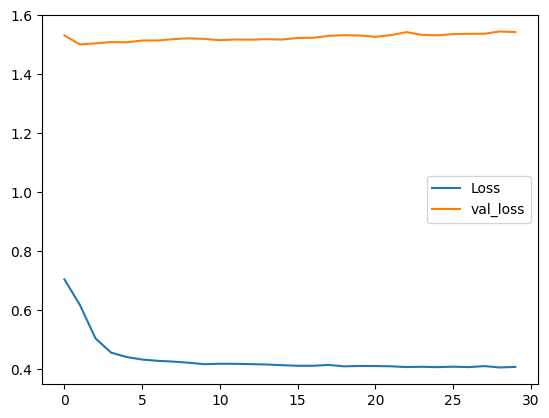

In [14]:
# , this is with heavy dropout in lstm
import matplotlib.pyplot as plt
plt.plot(blstm.history['loss'], label='Loss')
plt.plot(blstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### BLSTM batch_size=64
### 100 units, 20 epochs, solo dropout=0.2, loss=mse

In [ ]:
# try bidirectional
#https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# https://keras.io/api/layers/recurrent_layers/bidirectional/
# https://www.google.com/search?q=why+only+one+layer+is+enough+lstm&oq=why+only+one+layer+is+enough+lstm&aqs=chrome..69i57j33i160l3j33i299l3.3544j0j1&sourceid=chrome&ie=UTF-8
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional

from keras.preprocessing import sequence

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

blstm_model.reset_states()


blstm_model = Sequential()
blstm_model.add(Bidirectional(LSTM(100, activation='relu', recurrent_activation='tanh', input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=False)))
blstm_model.add(Dropout(0.2))

# model.add(Dropout(0.09))
blstm_model.add(Dense(1, activation='linear'))

blstm_model.compile(loss='mean_squared_error', optimizer='adam')
# https://medium.com/@canerkilinc/selecting-optimal-lstm-batch-size-63066d88b96b#:~:text=By%20experience%2C%20in%20most%20cases,based%20on%20the%20performance%20observation. 
# optimal batch size = 60
blstm = blstm_model.fit(r.x_train, r.y_train, epochs=20, batch_size=64, validation_split=0.1,  verbose=1, shuffle=False, callbacks=[early_stopping])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(blstm.history['loss'], label='Loss')
plt.plot(blstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### BLSTM batch_size=64
### 30 units, 20 epochs, no dropout=0.2, loss=mae

In [ ]:
r.x_train.shape

In [ ]:
import tensorflow as tf

# try bidirectional
#https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# https://keras.io/api/layers/recurrent_layers/bidirectional/
# https://www.google.com/search?q=why+only+one+layer+is+enough+lstm&oq=why+only+one+layer+is+enough+lstm&aqs=chrome..69i57j33i160l3j33i299l3.3544j0j1&sourceid=chrome&ie=UTF-8
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional

from keras.preprocessing import sequence

blstm_model.reset_states()
blstm_model = Sequential()
blstm_model.add(Bidirectional(LSTM(30, activation='relu', recurrent_activation='tanh', input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=False)))


# model.add(Dropout(0.09))
blstm_model.add(Dense(1, activation='linear'))

# Huber is less prone to outliers aka COVID 19 BABY
# https://en.wikipedia.org/wiki/Huber_loss
blstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
# https://medium.com/@canerkilinc/selecting-optimal-lstm-batch-size-63066d88b96b#:~:text=By%20experience%2C%20in%20most%20cases,based%20on%20the%20performance%20observation. 
# optimal batch size = 64
blstm = blstm_model.fit(r.x_train, r.y_train, epochs=20, batch_size=64, validation_split=0.1,  verbose=1, shuffle=False, callbacks=[early_stopping])

In [ ]:
# plot for ^
plt.plot(blstm.history['loss'], label='Huber Loss')
plt.plot(blstm.history['mae'], label='mae')
plt.legend()
plt.show()

## BLSTM HELLA LAYERS AND HELLA UNITS PER LAYER BRO
### no recurrent activation no activation in any layers 
(saw this on kaggle) more doesn't mean better. We will go with one above. We will continue with that model below.
https://towardsdatascience.com/time-series-prediction-with-lstm-in-tensorflow-42104db39340 

In [ ]:
import tensorflow as tf

# try bidirectional
#https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# https://keras.io/api/layers/recurrent_layers/bidirectional/
# https://www.google.com/search?q=why+only+one+layer+is+enough+lstm&oq=why+only+one+layer+is+enough+lstm&aqs=chrome..69i57j33i160l3j33i299l3.3544j0j1&sourceid=chrome&ie=UTF-8
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, Lambda

from keras.preprocessing import sequence

blstm_model.reset_states()
blstm_model = Sequential()

# blstm_model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))
blstm_model.add(Bidirectional(LSTM(1024, input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=True)))
blstm_model.add(Bidirectional(LSTM(512, input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=True)))
blstm_model.add(Bidirectional(LSTM(256, input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=True)))
blstm_model.add(Bidirectional(LSTM(128, input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=True)))
blstm_model.add(Bidirectional(LSTM(64, input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=False)))

# model.add(Dropout(0.09))
blstm_model.add(Dense(1))

# Huber is less prone to outliers aka COVID 19 BABY
# https://en.wikipedia.org/wiki/Huber_loss
blstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
# https://medium.com/@canerkilinc/selecting-optimal-lstm-batch-size-63066d88b96b#:~:text=By%20experience%2C%20in%20most%20cases,based%20on%20the%20performance%20observation. 
# optimal batch size = 64
blstm = blstm_model.fit(r.x_train, r.y_train, epochs=20, batch_size=64, validation_split=0.1,  verbose=1, shuffle=False, callbacks=[early_stopping])

In [ ]:
plt.plot(blstm.history['loss'], label='Huber Loss')
plt.plot(blstm.history['mae'], label='mae')
plt.legend()
plt.show()

In [ ]:

# try bidirectional
#https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# https://keras.io/api/layers/recurrent_layers/bidirectional/
# https://www.google.com/search?q=why+only+one+layer+is+enough+lstm&oq=why+only+one+layer+is+enough+lstm&aqs=chrome..69i57j33i160l3j33i299l3.3544j0j1&sourceid=chrome&ie=UTF-8
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional

from keras.preprocessing import sequence

blstm_model.reset_states()
blstm_model = Sequential()
# recurrent: activate input/forget/output gate
# activation: cell state and hidden state
blstm_model.add(Bidirectional(LSTM(30, activation='relu', recurrent_activation='tanh', input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=False)))

# https://datascience.stackexchange.com/questions/38205/dropout-on-which-layers-of-lstm#:~:text=The%20logic%20of%20drop%20out,layers%20after%20the%20LSTM%20layers.
# says dropout layer should not be added due to lstm's affinity for not remembering many things at once
# chance of forgetting something that should not be forgotten
# model.add(Dropout(0.09))
blstm_model.add(Dense(1, activation='linear'))

# Huber is less prone to outliers 
# aka COVID 19 BABY
# https://en.wikipedia.org/wiki/Huber_loss
blstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
# https://medium.com/@canerkilinc/selecting-optimal-lstm-batch-size-63066d88b96b#:~:text=By%20experience%2C%20in%20most%20cases,based%20on%20the%20performance%20observation. 
# optimal batch size = 64
blstm = blstm_model.fit(r.x_train, r.y_train, epochs=20, batch_size=64, validation_split=0.1,  verbose=1, shuffle=False, callbacks=[early_stopping])

## BLSTM DENSE LINEAR

In [ ]:
# try bidirectional
#https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# https://keras.io/api/layers/recurrent_layers/bidirectional/
# https://www.google.com/search?q=why+only+one+layer+is+enough+lstm&oq=why+only+one+layer+is+enough+lstm&aqs=chrome..69i57j33i160l3j33i299l3.3544j0j1&sourceid=chrome&ie=UTF-8
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional

from keras.preprocessing import sequence

blstm_model = Sequential()
blstm_model.reset_states()
blstm_model.add(Bidirectional(LSTM(64, activation='relu', dropout=0.09, recurrent_activation='tanh', input_shape=(r.x_train.shape[1], r.x_train.shape[2]), return_sequences=False)))
# model.add(LSTM(64, activation='sigmoid', return_sequences=True))
# model.add(LSTM(128, activation='sigmoid', return_sequences=True))
# model.add(LSTM(64, activation='sigmoid', return_sequences=True))
# model.add(LSTM(32, activation='sigmoid', return_sequences=False))

# model.add(Dropout(0.09))
blstm_model.add(Dense(1, activation='linear'))

blstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
blstm = blstm_model.fit(r.x_train, r.y_train, epochs=30, batch_size=64, validation_split=0.1,  verbose=1, shuffle=False)

In [ ]:
data_to_array_steps(array_steps_df, time_steps, d.columns, 'county_name')

In [ ]:
def data_to_array_steps(array_steps_df, time_steps, columns_to_array, id_column):
    """
    https: //www.mikulskibartosz.name/ how - to - turn - pandas - data - frame - into - time - series - input - for -rnn /
    :param array_steps_df: the dataframe from the csv
    :param time_steps: how many time steps
    :param columns_to_array: what columns to convert to the array
    :param id_column: what is to be used for the identifier
    :return: data grouped in a # observations by identifier and date
    """

    id_list = array_steps_df[id_column].unique().tolist()
    date_list = array_steps_df['date'].unique().tolist()

    master_list = []
    target_list = []

    missing_counter = 0
    total_counter = 0

    # grab date size = time steps at a time and iterate through all of them
    for date in range(len(date_list) - time_steps + 1):
        date_range_test = date_list[date:time_steps+date]

        date_range_df = array_steps_df.loc[(array_steps_df['date'] <= date_range_test[-1]) &
                                           (array_steps_df['date'] >= date_range_test[0])
                                          ]

        # for each id do it separately so time series data doesn't get mixed up
        for identifier in id_list:

            # get id in here and then skip if not the required time steps/observations for the id

            date_range_id = date_range_df.loc[date_range_df[id_column] == identifier]

            master_dict = {}

        # if there aren't enough observations for the data range
            if len(date_range_id) != time_steps:

                # dont fully need the counter except in unusual circumstances when debugging it causes no harm for now
                missing_counter += 1

            else:
            # add target each loop through for the last date in the date range for the id or ticker
                target = array_steps_df['target'].\
                         loc[(array_steps_df['date'] == date_range_test[-1])
                           & (array_steps_df[id_column] == identifier)                                     
                            ].iloc[0]

                target_list.append(target)

                total_counter += 1

                # loop through each column in dataframe
                for column in columns_to_array:

                    date_range_id_value = date_range_id[[column]].values

                    master_dict[column] = []
                    master_dict[column].append(date_range_id_value)

                master_list.append(master_dict)

    # redo columns to arrays, after they have been ordered and grouped by Id above
    array_list = []

    # for each column go through the values in the array create an array for the column then append to list
    for column in columns_to_array:

        for idx, dic in enumerate(master_list):
            # init arrays here if the first value
            if idx == 0:
                 value_array_init = master_list[0][column]

            else:
                 value_array_init += master_list[idx][column]

        array_list.append(np.array(value_array_init))

    # for each value in the array list, horizontally stack each value
    all_array = np.hstack(array_list).reshape((total_counter,
                                               len(columns_to_array),
                                               time_steps
                                               )
                                             ).transpose(0, 2, 1)

    target_array_all = np.array(target_list
                                ).reshape(len(target_list),
                                          1)

    # should probably make this an if condition later after a few more tests
    print('check of length of arrays', len(all_array), len(target_array_all))

    return all_array, target_array_all


In [ ]:
# tried embeddiung entity

In [ ]:
cont, cat = cont_cat_split(d, max_card=24, dep_var='median_listing_price')
cont, cat
procs_nn = [Categorify]
splits = RandomSplitter(seed=23)(d)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

to = TabularPandas(d, procs_nn, cat, cont,
                      splits=splits, y_names='median_listing_price')
dls = to_nn.dataloaders(1024, device = device)
learn = tabular_learner(dls, layers=[500,250], n_out=1)
learn.fit_one_cycle(8, 5e-4)
def embed_features(learner, xs):
  """
  learner: fastai Learner used to train the neural net
  xs: DataFrame containing input variables with nominal values defined by their rank.
  ::returns:: a copy of `xs` with embeddings replacing each categorical variable
  """
  xs = xs.copy()
  for i,col in enumerate(learn.dls.cat_names):
    emb = learn.model.embeds[i]
    emb_data = emb(tensor(xs[col], dtype=torch.int64).to(device))
    emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]
    feat_df = pd.DataFrame(data=emb_data, index=xs.index, columns=emb_names)
    xs = xs.drop(col, axis=1)
    xs = xs.join(feat_df)
  return xs
emb_xs = embed_features(learn, to.train.xs)
emb_valid_xs = embed_features(learn, to.valid.xs)

In [ ]:
d_train = d[d.date<"2021-07-01"]
d_test = d[d.date>="2021-04-01"]

# train
x_train = d_train.loc[:, d_train.columns != 'median_listing_price']
x_test = d_test.loc[:, d_test.columns != 'median_listing_price']
# test
y_train = d_train['median_listing_price']
y_test = d_test['median_listing_price']
# var split
cat_vars = ['county_name']
cont = list(x_train.columns)
cont.remove('date')
cont.remove('county_name')

D_train = []
D_test = []
D_train.append(x_train[cont].astype('float64').values)
D_train.append(x_train[cat_vars].values)
D_test.append(x_test[cat_vars].values)
D_test.append(x_test[cont].astype('float64').values)

In [ ]:
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = train_data[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

In [ ]:
from keras.layers import Dense, Dropout, Embedding, Input, Reshape, Concatenate
from keras.models import Model
import keras.backend as K

def custom_smape(x, x_):
    return K.mean(2*K.abs(x-x_)/(K.abs(x)+K.abs(x_)))


In [ ]:
ins = []
concat = []
for cat in cat_vars:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
    x = Reshape((cat_embsizes[cat],))(x)
    concat.append(x)

y = Input((len(cont),), name='cont_vars')
ins.append(y)
concat.append(y)

In [ ]:
y = Concatenate()(concat)
y = Dense(100, activation= 'relu')(y)
y = Dense(1)(y)
model = Model(ins, y)
model.compile('adam')

In [ ]:
# try sliding window panel
# https://stackoverflow.com/questions/40008240/how-to-process-panel-data-for-use-in-a-recurrent-neural-network-rnn
# https://timeseriesai.github.io/tsai/data.preparation.html#SlidingWindowPanel

from tsai.data.preparation import SlidingWindowPanel
# d2
d2_train = d2[d2['date']<='2022-05-01']
d2_test = d2[d2['date']>'2022-05-01']

xvars = ['unemployment_rate','active_listing_count','median_days_on_market', 'median_listing_price']

scaler = StandardScaler()
enc = LabelEncoder()
train_data = pd.DataFrame()
train_data[d2.columns] = d2

train_columns_to_scale = list(train_data.columns)
train_data[xvars] = scaler.fit_transform(train_data[xvars])
train_data['county_name'] = enc.fit_transform(train_data['county_name'])
train_data.set_index('date',inplace=True)

d2_Xtrain, d2_ytrain = X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['county_name'], stride=1, start=0, get_x=xvars.remove('median_listing_price')
                                                 , get_y=['median_listing_price'], horizon=1, seq_first=True, sort_by=['date'], ascending=True, return_key=False)(train_data)


In [ ]:
d2_Xtrain.shape, d2_ytrain.shape

In [ ]:
# try bidirectional
#https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# https://keras.io/api/layers/recurrent_layers/bidirectional/
# https://www.google.com/search?q=why+only+one+layer+is+enough+lstm&oq=why+only+one+layer+is+enough+lstm&aqs=chrome..69i57j33i160l3j33i299l3.3544j0j1&sourceid=chrome&ie=UTF-8
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, TimeDistributed

from keras.preprocessing import sequence

blstm_model = Sequential()
blstm_model.reset_states()
blstm_model.add(Bidirectional(LSTM(64, activation='sigmoid', dropout=0.09, recurrent_activation='tanh', input_shape=(74, d2_X.shape[2]), return_sequences=False)))
# model.add(LSTM(64, activation='sigmoid', return_sequences=True))
# model.add(LSTM(128, activation='sigmoid', return_sequences=True))
# model.add(LSTM(64, activation='sigmoid', return_sequences=True))
# model.add(LSTM(32, activation='sigmoid', return_sequences=False))

#https://stackoverflow.com/questions/60344253/lstm-model-has-constant-accuracy-and-doesnt-variate

blstm_model.add(Dense(1, activation='linear'))

# https://stackoverflow.com/questions/45632549/why-is-the-accuracy-for-my-keras-model-always-0-when-training

blstm_model.compile(loss='mse', optimizer='adam')# , metrics=['accuracy'])
blstm = blstm_model.fit(d2_Xtrain, d2_ytrain, epochs=30, batch_size=160, validation_split=0.1,  verbose=1, shuffle=False)

In [ ]:
plt.plot(blstm.history['loss'], label='Loss')
plt.plot(blstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

ypred=blstm_model.predict(rdat.x_test)
# check length
ypred.shape,rdat.y_test.shape